In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [2]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

In [3]:
# creating a chat prompt template
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a Twitter expert assigned to craft outstanding tweets.
            Generate the most engaging and impactful tweet possible based on the user's request.
            If the user provides feedback, refine and enhance your previous attempts accordingly for maximum engagement.''',
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)

llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0.7)

# using LCEL to create the generate_chain
generate_chain  = generation_prompt | llm

In [4]:
tweet = ''
request = HumanMessage(
    content='FIFA World Cup 26'
)

for chunk in generate_chain.stream(
    {'messages': [request]}
): 
    print(chunk.content, end='')
    tweet += chunk.content

🌍⚽️ Get ready for the #FIFAWorldCup2026! 🇺🇸🇨🇦🇲🇽 Three nations, one epic tournament! Who will lift the trophy? 🏆✨ Let the countdown begin! 🕒🔥 #FootballFever #RoadTo2026 #WorldCupMagic

In [5]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a Twitter influencer known for your engaging content and sharp insights.
            Review and critique the user’s tweet.
            Provide constructive feedback, focusing on enhancing its depth, style, and overall impact.
            Offer specific suggestions to make the tweet more compelling and engaging for their audience.'''
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)

reflect_chain  = reflection_prompt | llm

In [6]:
reflection = ""

for chunk in reflect_chain.stream(
    {"messages": [request, HumanMessage(content=tweet)]}
):
    print(chunk.content, end="")
    reflection += chunk.content

Your tweet captures the excitement of the upcoming FIFA World Cup 2026 nicely! The use of emojis is engaging and adds visual interest, which is perfect for Twitter. However, there are a few ways to enhance its depth, style, and overall impact:

1. **Add a Personal Touch**: Share your own anticipation or a personal memory related to past World Cups. This can create a connection with your audience. For example: "Can't wait to see the passion and talent on display—remember the thrill of 2014? 🥳"

2. **Pose a Question**: You’ve asked who will lift the trophy, but consider adding a more specific question to spark conversation. For instance: "Which underdog team do you think could surprise us this year?" 

3. **Highlight Unique Aspects**: Mention something unique about this tournament, like the fact that it's the first time three countries are co-hosting or the expanded format. This could deepen the context for your audience. 

4. **Call to Action**: Encourage your followers to engage furthe

In [7]:
for chunk in generate_chain.stream(
    {"messages": [request, AIMessage(content=tweet), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")


🌍⚽️ The excitement for #FIFAWorldCup2026 is REAL! 🇺🇸🇨🇦🇲🇽 Three nations, one epic showdown! 🏆✨ Can’t wait to see the passion on display—who else remembers the thrill of 2014? 🎉 What underdog team do you think could surprise us? Drop your predictions below! 👇 Let the countdown begin! 🕒🔥 #FootballFever #RoadTo2026 #WorldCupMagic

In [ ]:
from typing import List, Sequence
from langgraph.graph import END, MessageGraph

def generation_node(state: Sequence[BaseMessage]):
    return generate_chain.invoke({"messages": state})


def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    translated = [messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
        ]
    res = reflect_chain.invoke({"messages": translated})
    return HumanMessage(content=res.content)

builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)

builder.set_entry_point("generate")


MAX_ITERATIONS = 6

def should_continue(state: List[BaseMessage]):
    if len(state) > MAX_ITERATIONS:
        return END
    return "reflect"

builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

graph = builder.compile()

/var/folders/rg/_gpzq28d4m5bz9kt_j3vlkk00000gn/T/ipykernel_63652/3627582599.py:16: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  builder = MessageGraph()


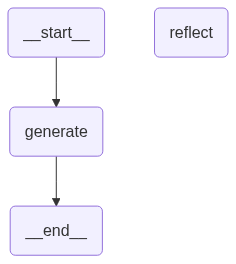

In [9]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
inputs = HumanMessage(content="Generate a tweet about FIFA World Cup 26")
response = graph.invoke(inputs)

In [11]:
for resp in response:
    print(resp.content)
    print("\n" + "-" * 100 + "\n")

Generate a tweet about FIFA World Cup 26

----------------------------------------------------------------------------------------------------

🌍⚽️ The countdown to #FIFAWorldCup26 has begun! 🎉 Get ready for a month of unforgettable matches, diverse cultures, and the world's best talent on display! Which team are you cheering for? 🏆🇺🇸🇨🇦🇲🇽 #WorldCup #FootballFever #26InTheMaking

----------------------------------------------------------------------------------------------------

Your tweet captures the excitement surrounding the FIFA World Cup 2026 nicely! The emojis add a fun touch, and the question at the end encourages engagement. However, to enhance its depth and style, consider the following suggestions:

1. **Add a Personal Touch**: Share a brief insight or thought about what the World Cup means to you or a memorable moment from past tournaments. This will make your tweet more relatable and engaging.

2. **Highlight Specifics**: Mention a few standout players or teams to spark co